# A Finite Element Solution for a plate with MATLAB code.

The problem is show in the figure 6-16. 

![Figure 1](figure1.JPG)

This problem is show in the chapter 6.5 of the book: *A firts Course in the Finite Element Method* written by Daryl L. Logan. In this 
chapter a solution is make by subdivided the plate in two CST. The purpose of this project is to make more divisions considering 400 CST and see the results. 

## Preprocesing 

In [86]:
% Geometry definition 

%The mesh is divided in n_x*n_y squares, n_x division in the x direction and n_y divisions in the y direction. 
%At each rectangle the CST is generated joining the lower-left node with the upper-right node of the rectangle. 

t = 1; % in
E = 30*10^6; %psi
v = 0.3; 
n_x = 100; 
n_y = 100;
x0 = 0;
y0 = 0;
x1 = 20;
y1 = 10; 
x = linspace(x0,x1,n_x+1); 
y = linspace(y0,y1,n_y+1); 
%Surface Forces
p = 1000;

## Solution as approximation of one element 

If one element is used, the displacement is going to be:
$$
\delta = \frac{P L}{E A}
$$
This result can be used to compare the values of the CST method with one element method. This value is situable for displacements in $x$ ($U_{xy}$) in the graphics. 

In [74]:
A = (y1-y0)*t;
L = (x1-x0);
displacement_x_one_element = p*A*L/(E*A);
displacement_x_one_element


displacement_x_one_element =

   6.6667e-04




## Formulation and Assembly 

In [87]:
%Assembly 

%Numeration of nodes
%This function enumerate the nodes from left to right starting in the coordinate (1,1)
node_numeration = @(i,j) (j-1)*(n_x+1)+i; 

%Global matrix
n_nodes = (n_x+1)*(n_y+1); 
ndfo = 2*n_nodes; 
K = sparse(ndfo,ndfo);

%Vector of global displacements 
D = NaN(ndfo,1);
%Vector of global Forces; 
Q = NaN(ndfo,1);

%Surface force 
%The surface force is divided in each element so the force in each element is (p*L*t), then it is transmitted 
%to the nodes with the value (pLt/2) to each node. 

%Value of L
%Because of the problem L es divided in the y direction 
L = (y1-y0)/n_y;
sign_value = 1; % (-1) for comprension and (+1) for traction 
%Node force 
node_force = sign_value*p*L*t/2;

%Assembly
for i = 1:n_x
    for j = 1:n_y
        %Application of the boundary conditions 
        if i == 1
            n0 = node_numeration(i,j);
            dfo0 = [2*n0-1,2*n0];
            d = [0;0];
            D(dfo0) = d;
            %Additionally:
            if j == n_y
               %node (1,j+1) 
               n1 = node_numeration(i,j+1);
               dfo1 = [2*n1-1,2*n1]; 
               D(dfo1) = d;
            end
        end 
        
        %Calculation of surface forces and assembly of the vector of global Forces 
        if i == n_x
            n0 = node_numeration(i+1,j);
            dfo0 = [2*n0-1,2*n0];
            q = [node_force;0];
            
            if j == 1
                Q(dfo0) = q;  
            else 
                Q(dfo0) = 2*q;
            end
            
            %Additionally:  
            if j == n_y
                %node (i+1,j+1)
                n1 = node_numeration(i+1,j+1);
                dfo1 = [2*n1-1,2*n1]; 
                Q(dfo1) = q;
            end    
        end
        %Cero forces
        
        if (i>1)&&(i<=n_x)
            n0 = node_numeration(i,j);
            df0 = [2*n0-1,2*n0];
            q = [0;0];
            Q(df0) = q;
        end
        
        %Additionally
        if (i>1)&&(j == n_y)
            n0 = node_numeration(i,j+1);
            df0 = [2*n0-1,2*n0];
            q = [0;0];
            Q(df0) = q;
        end
        
        %Calculation of local stiffness matrix and assembly to global stiffness matrix 
        %The local stiffness matrix was coded in the file: "local_stiffness_matrix.m"
        %Local nodes transformed to global nodes numeration 
        n1 = node_numeration(i,j);
        n2 = node_numeration(i+1,j);
        n3 = node_numeration(i+1,j+1);
        n4 = node_numeration(i,j+1); 
        
        %Nodes coordinates
        x1 = x(i); y1 = y(j);
        x2 = x(i+1); y2 = y(j);
        x3 = x(i+1); y3 = y(j+1);
        x4 = x(i); y4 = y(j+1);
        
        %Triangle1: n1(x1,y1), n3(x3,y3), n4(x4,y4) 
        k1 = local_stiffness_matrix(x1,y1,x3,y3,x4,y4,E,v,t);
        
        %Degrees of freedom numeration 
        dfo1 = [2*n1-1,2*n1,2*n3-1,2*n3,2*n4-1,2*n4];
        
        %Assembly
        K(dfo1,dfo1) = K(dfo1,dfo1) + k1;

        %Triangle2: n1(x1,y1), n2(x2,y2), n3(x3,y3) 
        k2 = local_stiffness_matrix(x1,y1,x2,y2,x3,y3,E,v,t);
        
        %Degrees of freedom numeration 
        dfo2 = [2*n1-1,2*n1,2*n2-1,2*n2,2*n3-1,2*n3];
        
        %Assembly
        K(dfo2,dfo2) = K(dfo2,dfo2) + k2;
    end
end

## Solution of the equation Q = K*D

In [88]:
%We subdivided the matrices 
%u is used for unknown and k for known 
D_k_positions = find(~isnan(D)); %The displacements that are imposed
D_u_positions = find(isnan(D)); %The displacements that we don't known

K_uu = K(D_u_positions,D_u_positions);
K_uk = K(D_u_positions,D_k_positions);
K_kk = K(D_k_positions,D_k_positions);
K_ku = K(D_k_positions,D_u_positions);

D_u = D(D_u_positions);
D_k = D(D_k_positions);
Q_k = Q(D_u_positions);%Values of Q in the dfo where the displacements are not known 

D_u = K_uu\(Q_k-K_uk*D_k);
Q_u = K_kk*D_k+K_ku*D_u;

D(D_u_positions) = D_u;
Q(D_k_positions) = Q_u;

## Graphics 

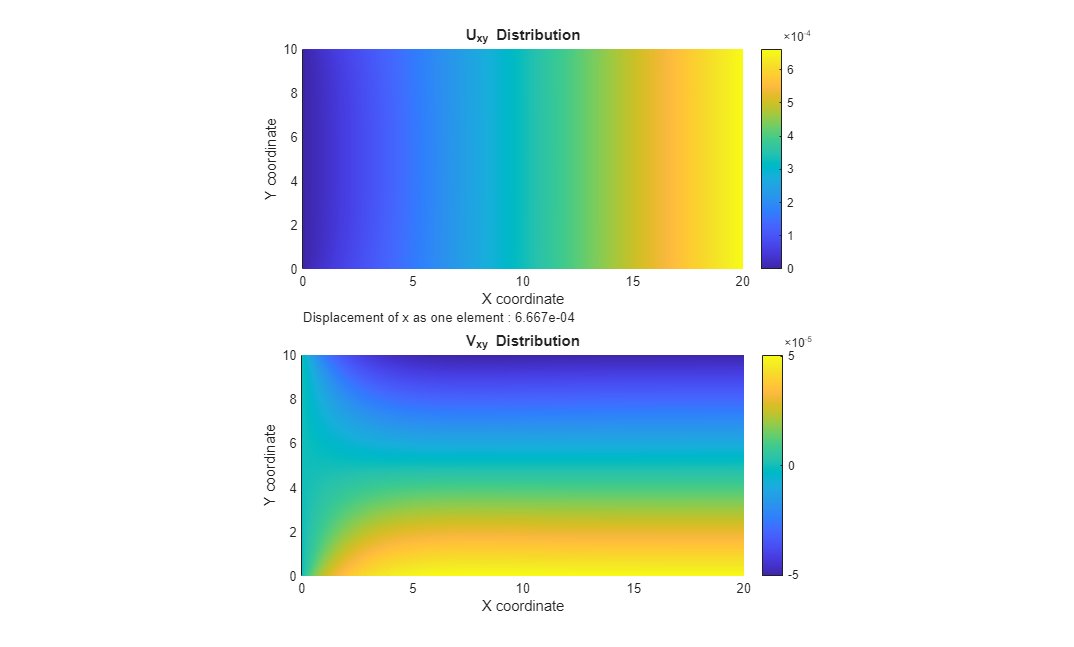

In [89]:
%How displacement change inside the element 
%For each element 
n_element_x = 10; 
n_element_y = 10;
U_x_y = zeros(n_y*n_element_y + 1, n_x*n_element_x + 1);
V_x_y = zeros(n_y*n_element_y + 1, n_x*n_element_x + 1);

for i = 1:(n_x)
    for j = 1:(n_y)
        %The rectangle (i,j,i+1,j+1) is divided into two triangles
        %counterclockwise the area is positive
        %Node numeration in the small rectangle 
        node_0 = node_numeration(i,j);
        node_1 = node_numeration(i+1,j);
        node_2 = node_numeration(i,j+1);
        node_3 = node_numeration(i+1,j+1);
        
        %First triangle
        x0 = [x(i),x(i+1),x(i+1)];
        y0 = [y(j),y(j),y(j+1)];
        u0 = [D(2*node_0-1),D(2*node_1-1),D(2*node_3-1)];
        v0 = [D(2*node_0),D(2*node_1),D(2*node_3)];
        
        %Second triangle
        x1 = [x(i),x(i+1),x(i)];
        y1 = [y(j),y(j+1),y(j+1)];
        u1 = [D(2*node_0-1),D(2*node_3-1),D(2*node_2-1)];
        v1 = [D(2*node_0),D(2*node_3),D(2*node_2)];
        
        %The limits for the rectangle
        xmin = min([x0,x1]);
        ymin = min([y0,y1]);
        xmax = max([x0,x1]);
        ymax = max([y0,y1]);
        local_x = linspace(xmin,xmax,n_element_x+1);
        local_y = linspace(ymin,ymax,n_element_y+1);
        u_local = zeros(length(local_y),length(local_x));
        v_local = zeros(length(local_y),length(local_x));
        
        %First triangle
        for k = 1:(n_element_y+1)   
            for m = 1:(n_element_x+1)
                %Verification that the point is inside the triangle
                lambda1 = barycentric_lambda(x0(1), y0(1), x0(2), y0(2), x0(3), y0(3), local_x(m), local_y(k));
                lambda2 = barycentric_lambda(x0(2), y0(2), x0(3), y0(3), x0(1), y0(1), local_x(m), local_y(k));
                lambda3 = barycentric_lambda(x0(3), y0(3), x0(1), y0(1), x0(2), y0(2), local_x(m), local_y(k));
                if (lambda1<0) || (lambda2<0) || (lambda3<0)
                    continue; 
                end
                u_local(k,m) = u_x_y(u0(1),u0(2),u0(3),x0(1),y0(1),x0(2),y0(2),x0(3),y0(3),local_x(m), local_y(k));
                v_local(k,m) = u_x_y(v0(1),v0(2),v0(3),x0(1),y0(1),x0(2),y0(2),x0(3),y0(3),local_x(m), local_y(k));
            end
        end
        
        %Second triangle
        for k = 1:(n_element_y+1)     
            for m = 1:(n_element_x+1)
                %Verification that the point is inside the triangle
                lambda1 = barycentric_lambda(x1(1), y1(1), x1(2), y1(2), x1(3), y1(3), local_x(m), local_y(k));
                lambda2 = barycentric_lambda(x1(2), y1(2), x1(3), y1(3), x1(1), y1(1), local_x(m), local_y(k));
                lambda3 = barycentric_lambda(x1(3), y1(3), x1(1), y1(1), x1(2), y1(2), local_x(m), local_y(k));
                if (lambda1<0) || (lambda2<0) || (lambda3<0)
                    continue; 
                end
                u_local(k,m) = u_x_y(u1(1),u1(2),u1(3),x1(1),y1(1),x1(2),y1(2),x1(3),y1(3),local_x(m), local_y(k));
                v_local(k,m) = u_x_y(v1(1),v1(2),v1(3),x1(1),y1(1),x1(2),y1(2),x1(3),y1(3),local_x(m), local_y(k));
            end
        end
        
        %Assembly
        row_start = (j-1)*n_element_y + 1;
        row_end = j*n_element_y + 1;
        col_start = (i-1)*n_element_x + 1;
        col_end = i*n_element_x + 1;

        U_x_y(row_start:row_end, col_start:col_end) = u_local;
        V_x_y(row_start:row_end, col_start:col_end) = v_local;
    end
end

%Figures U_x_y V_x_y

x_plot = linspace(min(x),max(x),n_x*n_element_x+1);
y_plot = linspace(min(y),max(y),n_y*n_element_y+1);
[X,Y] = meshgrid(x_plot, y_plot);

%With this code the values in the matrix U_x_y and V_x_y in the final column and final row are lost in the graphic because the rectangle
%take its color using the information of the left lower node. 
figure;
subplot(2,1,1);
pcolor(X, Y, U_x_y);
axis equal tight;
shading flat; 
colorbar;
title('U_x_y Distribution');
xlabel('X coordinate');
ylabel('Y coordinate');
y_text_position = min(y_points) - (max(y_points) - min(y_points)) * 0.22; 
text(min(x_points), y_text_position, sprintf('Displacement of x as one element : %.3e', displacement_x_one_element), 'FontSize', 10, 'Interpreter', 'none');

subplot(2,1,2);
pcolor(X, Y, V_x_y);
axis equal tight;
shading flat;
colorbar;
title('V_x_y Distribution');
xlabel('X coordinate');
ylabel('Y coordinate');

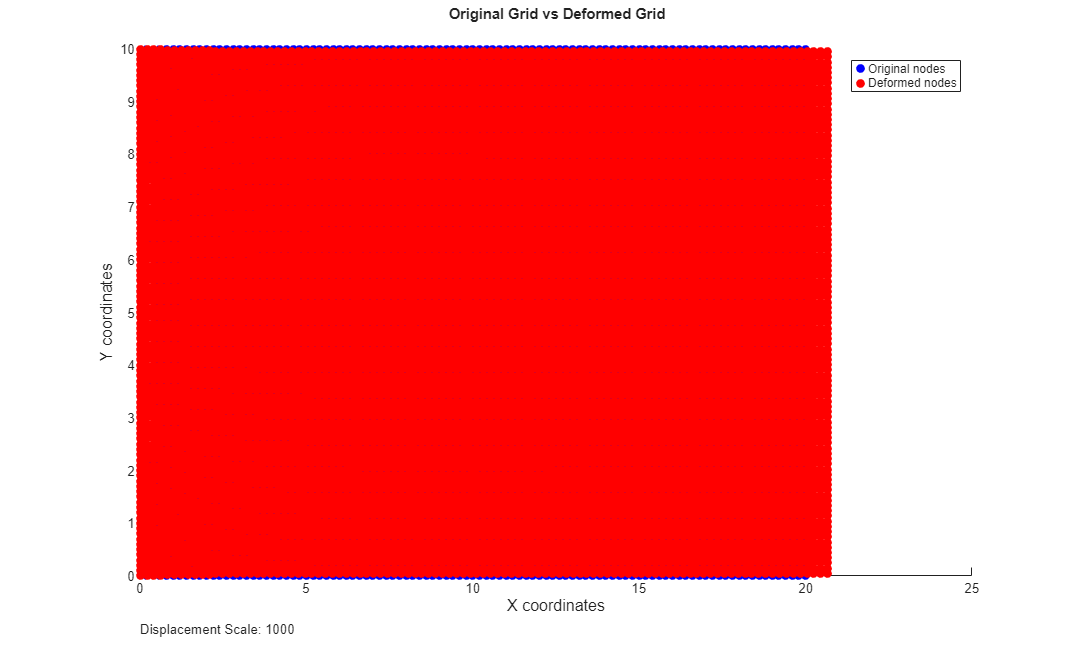

In [90]:
%Coordinates with displacements 

%Original Coordinates
[X_grid,Y_grid] = meshgrid(x,y);
X_grid_tra = X_grid';
Y_grid_tra = Y_grid';
x_points = X_grid_tra(:);
y_points = Y_grid_tra(:);
%Displacements of u for x with corresponds to the odd dfos and v for y with even dfos. 
u = D(1:2:end);
v = D(2:2:end);
displacement_scale = 1000;%to diferentiate te results

%Displacements in x and y 
x_displaced = x_points +u*displacement_scale;
y_displaced = y_points +v*displacement_scale;

%Figures 
figure;
hold on; 
% original nodal points and displaced nodal points 
plot(X_grid(:), Y_grid(:), 'bo', 'MarkerFaceColor', 'b');
plot(x_displaced, y_displaced, 'ro', 'MarkerFaceColor', 'r');
hold off; 

%Titles, axes titles, legends and texts

h = title('Original Grid vs Deformed Grid', 'Units', 'Normalized');
set(h, 'Position', [0.5, 1.05, 0]);

xlabel('X coordinates','FontSize', 12);
ylabel('Y coordinates','FontSize', 12);
legend('Original nodes','Deformed nodes');
y_text_position = min(y_points) - (max(y_points) - min(y_points)) * 0.1; 
text(min(x_points), y_text_position, sprintf('Displacement Scale: %d', displacement_scale), 'FontSize', 10, 'Interpreter', 'none');